In [5]:
import os, sys
import numpy as np
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, top_k_accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import preprocessor as p
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.dataset import load_dataset
from src.model.BiLSTMClassifier import EnhancedBiLSTM
from src.embedding_matrix import *

In [4]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

False


# BiLTSM Model
- On GloVe Twitter Embeddings(100d)
- On FastText Crawl Subwords Embeddings(300d)

In [32]:
train, _, _, _ = load_dataset()

X = train["TEXT"].values.astype("U")
y = train["Label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
vocab = create_vocab()

glove_embeddings = load_pretrained_embeddings("glove-twitter-100")
create_embedding_matrix_glove(vocab, glove_embeddings)

glove_embeddings_200d = load_pretrained_embeddings("glove-twitter-200")
create_embedding_matrix_glove(vocab, glove_embeddings_200d)

fasttext_embeddings = load_fasttext()
create_embedding_matrix_fasttext(vocab, fasttext_embeddings)

In [14]:
def top_k_accuracy(predict):
    y_scores = np.zeros((len(X_test), 20))
    top_k_accs = {}

    for i, (_, scores) in enumerate(predict):
        for label, score in scores.items():
            y_scores[i, label] = score

    for k in [1, 3, 5]:
        acc = top_k_accuracy_score(y_test, y_scores, k=k)
        top_k_accs[f"top_{k}_accuracy"] = acc

    return top_k_accs

## GloVe Twitter Embeddings(100d)

In [33]:
embedding_matrix_glove = np.load("../data/embeddings/embedding_matrix_glove_twitter_100.npy")
vocab = np.load("../data/embeddings/vocab.npy", allow_pickle=True).item()

vocab_size, embedding_dim_glove = embedding_matrix_glove.shape
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 45397


In [34]:
tokenizer = TweetTokenizer()

def encode(text, vocab, max_len=50):
    text = p.tokenize(text)
    tokens = tokenizer.tokenize(text.lower())
    ids = [vocab.get(t, vocab["<UNK>"]) for t in tokens]
    if len(ids) < max_len:
        ids = ids + [vocab["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

max_len = 50

X_train_ids_glove = np.array([encode(t, vocab, max_len) for t in X_train])
X_test_ids_glove  = np.array([encode(t, vocab, max_len) for t in X_test])

In [36]:

batch_size = 64
num_classes = len(np.unique(y_train))

train_dataset_glove = TensorDataset(
    torch.tensor(X_train_ids_glove, dtype=torch.long),
    torch.tensor(y_train, dtype=torch.long)
)
train_loader_glove = DataLoader(train_dataset_glove, batch_size=batch_size, shuffle=True)

model_glove = EnhancedBiLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim_glove,
    hidden_dim=128,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_glove,
    freeze_embeddings=True,
    num_layers=3,
    dropout=0.3
)

optimizer = optim.Adam(model_glove.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [38]:
train_losses_glove = []
val_losses_glove = []
epochs = 10

for epoch in range(epochs):
    model_glove.train()
    total_loss = 0
    total = 0

    for x_batch, y_batch in train_loader_glove:
        optimizer.zero_grad()
        y_pred = model_glove(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
        total += x_batch.size(0)


    # Save the model
    torch.save(model_glove.state_dict(), f"models/bilstm_glove_twitter_{epoch+1}_epoches.pth")

    model_glove.eval()
    with torch.no_grad():
        X = torch.tensor(X_test_ids_glove, dtype=torch.long)
        logits = model_glove(X)
        pred = logits.argmax(dim=1).numpy()
        accuracy = (pred == y_test).mean()
        val_loss = criterion(logits, torch.tensor(y_test, dtype=torch.long)).item()

    train_losses_glove.append(total_loss / total)
    val_losses_glove.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss={total_loss / total:.4f}, Validation Loss={val_loss:.4f}, Validation Accuracy={accuracy:.4f}")



Epoch 1, Training Loss=2.5354, Validation Loss=2.3649, Validation Accuracy=0.3070
Epoch 2, Training Loss=2.3611, Validation Loss=2.2809, Validation Accuracy=0.3201
Epoch 3, Training Loss=2.2941, Validation Loss=2.2414, Validation Accuracy=0.3330
Epoch 4, Training Loss=2.2547, Validation Loss=2.2126, Validation Accuracy=0.3424
Epoch 5, Training Loss=2.2254, Validation Loss=2.1988, Validation Accuracy=0.3421
Epoch 6, Training Loss=2.1965, Validation Loss=2.1850, Validation Accuracy=0.3456
Epoch 7, Training Loss=2.1748, Validation Loss=2.1792, Validation Accuracy=0.3467
Epoch 8, Training Loss=2.1534, Validation Loss=2.1733, Validation Accuracy=0.3469
Epoch 9, Training Loss=2.1303, Validation Loss=2.1780, Validation Accuracy=0.3471
Epoch 10, Training Loss=2.1085, Validation Loss=2.1720, Validation Accuracy=0.3437


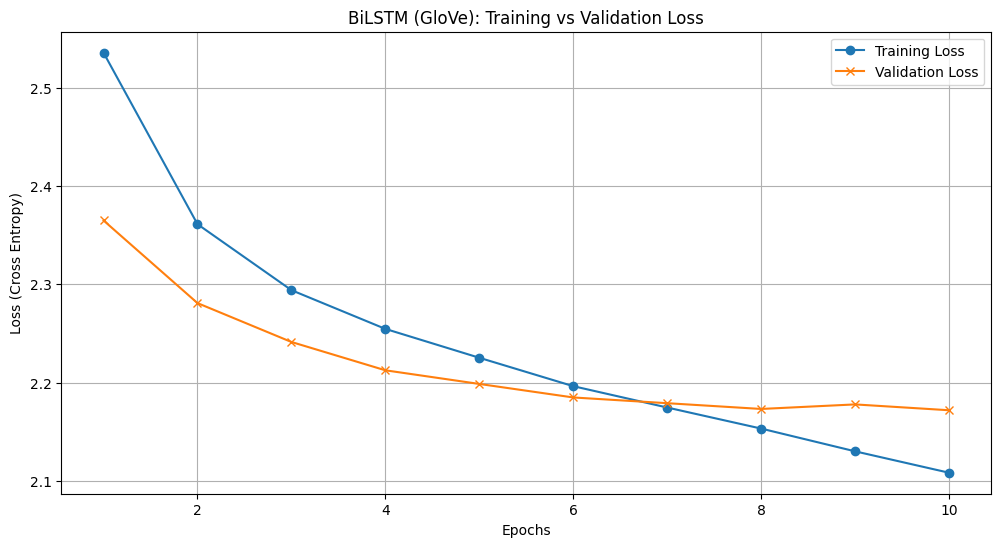

Top-K Accuracies: {'top_1_accuracy': 0.3437142857142857, 'top_3_accuracy': 0.6, 'top_5_accuracy': 0.7241428571428571}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       282
           1       0.37      0.62      0.47       531
           2       0.25      0.30      0.27      1408
           3       0.34      0.59      0.43      1384
           4       0.09      0.02      0.03       372
           5       0.60      0.69      0.64       387
           6       0.30      0.03      0.06       431
           7       0.47      0.47      0.47       875
           8       0.21      0.02      0.03       377
           9       0.34      0.63      0.44      3049
          10       0.29      0.01      0.01       355
          11       0.54      0.40      0.46       509
          12       0.28      0.46      0.35       370
          13       0.31      0.20      0.24       644
          14       0.30      0.01      0.02    

c:\Users\25381\.conda\envs\AL3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\25381\.conda\envs\AL3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\25381\.conda\envs\AL3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [39]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_losses_glove, label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses_glove, label='Validation Loss', marker='x')
plt.title('BiLSTM (GloVe): Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.grid(True)

plt.show()

# Save the model
torch.save(model_glove.state_dict(), "models/bilstm_glove_twitter_10_epoches.pth")

model_glove.eval()
with torch.no_grad():
    X = torch.tensor(X_test_ids_glove, dtype=torch.long)
    logits = model_glove(X)
    pred = logits.argmax(dim=1).numpy()
    preds = logits.softmax(dim=1).numpy()

    preds = [
        {label: score for label, score in enumerate(sample_scores)}
        for sample_scores in preds
    ]
    top_k_accs = top_k_accuracy(enumerate(preds))
    print("Top-K Accuracies:", top_k_accs)

    report = classification_report(y_test, pred)
    print("Classification Report:\n", report)

    val_loss = criterion(logits, torch.tensor(y_test, dtype=torch.long)).item()
    print(f"Final Validation Loss: {val_loss:.4f}")


## GloVe Twitter Embeddings(200d)

In [20]:
embedding_matrix_glove_200d = np.load("../data/embeddings/embedding_matrix_glove_twitter_200.npy")
vocab = np.load("../data/embeddings/vocab.npy", allow_pickle=True).item()

vocab_size, embedding_dim_glove_200d = embedding_matrix_glove_200d.shape
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 45397


In [21]:
tokenizer = TweetTokenizer()

def encode(text, vocab, max_len=50):
    text = p.tokenize(text)
    tokens = tokenizer.tokenize(text.lower())
    ids = [vocab.get(t, vocab["<UNK>"]) for t in tokens]
    if len(ids) < max_len:
        ids = ids + [vocab["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

max_len = 50

X_train_ids_glove_200d = np.array([encode(t, vocab, max_len) for t in X_train])
X_test_ids_glove_200d  = np.array([encode(t, vocab, max_len) for t in X_test])

In [29]:

batch_size = 64
num_classes = len(np.unique(y_train))

train_dataset_glove_200d = TensorDataset(
    torch.tensor(X_train_ids_glove_200d, dtype=torch.long),
    torch.tensor(y_train, dtype=torch.long)
)
train_loader_glove_200d = DataLoader(train_dataset_glove_200d, batch_size=batch_size, shuffle=True)

model_glove_200d = EnhancedBiLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim_glove_200d,
    hidden_dim=128,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_glove_200d,
    freeze_embeddings=True,
    num_layers=3,
    dropout=0.3
)

optimizer = optim.Adam(model_glove_200d.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [30]:
train_losses_glove_200d = []
val_losses_glove_200d = []
epochs = 20

for epoch in range(epochs):
    model_glove_200d.train()
    total_loss = 0
    total = 0

    for x_batch, y_batch in train_loader_glove_200d:
        optimizer.zero_grad()
        y_pred = model_glove_200d(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
        total += x_batch.size(0)

    # Save the model
    torch.save(model_glove_200d.state_dict(), f"models/bilstm_glove_twitter_200d3_{epoch+1}_epoches.pth")

    model_glove_200d.eval()
    with torch.no_grad():
        X = torch.tensor(X_test_ids_glove_200d, dtype=torch.long)
        logits = model_glove_200d(X)
        pred = logits.argmax(dim=1).numpy()
        accuracy = (pred == y_test).mean()
        val_loss = criterion(logits, torch.tensor(y_test, dtype=torch.long)).item()

    train_losses_glove_200d.append(total_loss / total)
    val_losses_glove_200d.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss={total_loss / total:.4f}, Validation Loss={val_loss:.4f}, Validation Accuracy={accuracy:.4f}")



Epoch 1, Training Loss=2.5144, Validation Loss=2.3340, Validation Accuracy=0.3120
Epoch 2, Training Loss=2.3152, Validation Loss=2.2349, Validation Accuracy=0.3354
Epoch 3, Training Loss=2.2473, Validation Loss=2.1997, Validation Accuracy=0.3418
Epoch 4, Training Loss=2.2052, Validation Loss=2.1819, Validation Accuracy=0.3498
Epoch 5, Training Loss=2.1673, Validation Loss=2.1765, Validation Accuracy=0.3497
Epoch 6, Training Loss=2.1334, Validation Loss=2.1790, Validation Accuracy=0.3507
Epoch 7, Training Loss=2.1044, Validation Loss=2.1619, Validation Accuracy=0.3526
Epoch 8, Training Loss=2.0714, Validation Loss=2.1696, Validation Accuracy=0.3494
Epoch 9, Training Loss=2.0373, Validation Loss=2.1687, Validation Accuracy=0.3456
Epoch 10, Training Loss=2.0019, Validation Loss=2.1877, Validation Accuracy=0.3482
Epoch 11, Training Loss=1.9710, Validation Loss=2.1813, Validation Accuracy=0.3474
Epoch 12, Training Loss=1.9418, Validation Loss=2.2121, Validation Accuracy=0.3472
Epoch 13, Tra

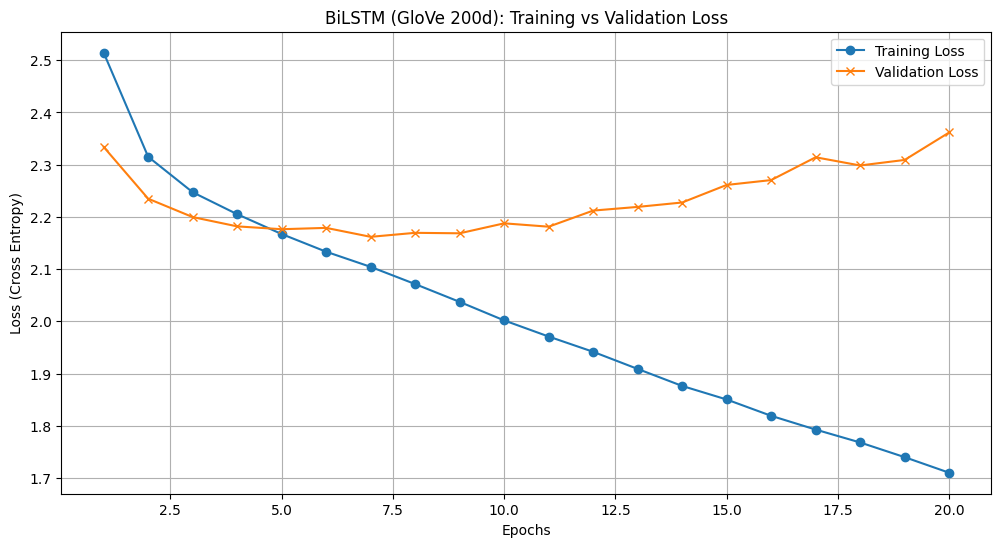

RuntimeError: Error(s) in loading state_dict for EnhancedBiLSTM:
	Missing key(s) in state_dict: "lstm.weight_ih_l2", "lstm.weight_hh_l2", "lstm.bias_ih_l2", "lstm.bias_hh_l2", "lstm.weight_ih_l2_reverse", "lstm.weight_hh_l2_reverse", "lstm.bias_ih_l2_reverse", "lstm.bias_hh_l2_reverse". 
	size mismatch for embedding.weight: copying a param with shape torch.Size([45397, 100]) from checkpoint, the shape in current model is torch.Size([45397, 200]).
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([512, 100]) from checkpoint, the shape in current model is torch.Size([512, 200]).
	size mismatch for lstm.weight_ih_l0_reverse: copying a param with shape torch.Size([512, 100]) from checkpoint, the shape in current model is torch.Size([512, 200]).

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_losses_glove_200d, label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses_glove_200d, label='Validation Loss', marker='x')
plt.title('BiLSTM (GloVe 200d): Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.grid(True)

plt.show()

# Load the best model

model_glove_200d.load_state_dict(torch.load("models/bilstm_glove_twitter_200d3_7_epoches.pth"))

model_glove_200d.eval()
with torch.no_grad():
    X = torch.tensor(X_test_ids_glove, dtype=torch.long)
    logits = model_glove(X)
    pred = logits.argmax(dim=1).numpy()
    preds = logits.softmax(dim=1).numpy()

    preds = [
        {label: score for label, score in enumerate(sample_scores)}
        for sample_scores in preds
    ]
    top_k_accs = top_k_accuracy(enumerate(preds))
    print("Top-K Accuracies:", top_k_accs)

    report = classification_report(y_test, pred)
    print("Classification Report:\n", report)

    val_loss = criterion(logits, torch.tensor(y_test, dtype=torch.long)).item()
    print(f"Final Validation Loss: {val_loss:.4f}")


## FastText Crawl Subwords Embeddings(300d)

In [ ]:
embedding_matrix_fasttext = np.load("../data/embeddings/embedding_matrix_crawl_subword_300.npy")
vocab = np.load("../data/embeddings/vocab.npy", allow_pickle=True).item()

vocab_size, embedding_dim_fasttext = embedding_matrix_fasttext.shape
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 45397


In [5]:
tokenizer = TweetTokenizer()

def encode(text, vocab, max_len=50):
    text = p.tokenize(text)
    tokens = tokenizer.tokenize(text.lower())
    ids = [vocab.get(t, vocab["<UNK>"]) for t in tokens]
    if len(ids) < max_len:
        ids = ids + [vocab["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

max_len = 50

X_train_ids_fasttext = np.array([encode(t, vocab, max_len) for t in X_train])
X_test_ids_fasttext  = np.array([encode(t, vocab, max_len) for t in X_test])

In [6]:

batch_size = 64
num_classes = len(np.unique(y_train))

train_dataset_fasttext = TensorDataset(
    torch.tensor(X_train_ids_fasttext, dtype=torch.long),
    torch.tensor(y_train, dtype=torch.long)
)
train_loader_fasttext = DataLoader(train_dataset_fasttext, batch_size=batch_size, shuffle=True)

model_fasttext = EnhancedBiLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim_fasttext,
    hidden_dim=128,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_fasttext,
    freeze_embeddings=True,
    num_layers=2,
    dropout=0.3
)

optimizer = optim.Adam(model_fasttext.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [7]:
train_losses_fasttext = []
val_losses_fasttext = []
epochs = 15

for epoch in range(epochs):
    model_fasttext.train()
    total_loss = 0
    total = 0

    for x_batch, y_batch in train_loader_fasttext:
        optimizer.zero_grad()
        y_pred = model_fasttext(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
        total += x_batch.size(0)

    # Save the model
    torch.save(model_fasttext.state_dict(), f"models/bilstm_fasttext_{epoch+1}_epoches.pth")

    model_fasttext.eval()
    with torch.no_grad():
        X = torch.tensor(X_test_ids_fasttext, dtype=torch.long)
        logits = model_fasttext(X)
        pred = logits.argmax(dim=1).numpy()
        accuracy = (pred == y_test).mean()
        val_loss = criterion(logits, torch.tensor(y_test, dtype=torch.long)).item()

    train_losses_fasttext.append(total_loss / total)
    val_losses_fasttext.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss={total_loss / total:.4f}, Validation Loss={val_loss:.4f}, Validation Accuracy={accuracy:.4f}")



Epoch 1, Training Loss=2.6537, Validation Loss=2.5166, Validation Accuracy=0.2611
Epoch 2, Training Loss=2.4650, Validation Loss=2.3853, Validation Accuracy=0.2974
Epoch 3, Training Loss=2.3769, Validation Loss=2.3176, Validation Accuracy=0.3134
Epoch 4, Training Loss=2.3198, Validation Loss=2.2819, Validation Accuracy=0.3214
Epoch 5, Training Loss=2.2851, Validation Loss=2.2516, Validation Accuracy=0.3273
Epoch 6, Training Loss=2.2584, Validation Loss=2.2410, Validation Accuracy=0.3321
Epoch 7, Training Loss=2.2396, Validation Loss=2.2219, Validation Accuracy=0.3369
Epoch 8, Training Loss=2.2195, Validation Loss=2.2116, Validation Accuracy=0.3368
Epoch 9, Training Loss=2.2055, Validation Loss=2.2128, Validation Accuracy=0.3372
Epoch 10, Training Loss=2.1902, Validation Loss=2.1989, Validation Accuracy=0.3437
Epoch 11, Training Loss=2.1733, Validation Loss=2.1933, Validation Accuracy=0.3443
Epoch 12, Training Loss=2.1605, Validation Loss=2.1943, Validation Accuracy=0.3426
Epoch 13, Tra

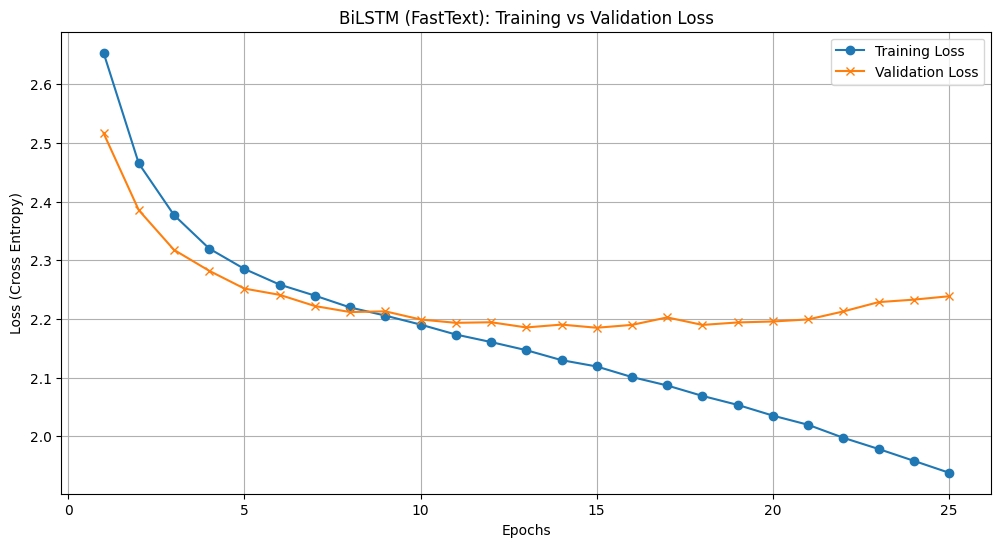

Top-K Accuracies: {'top_1_accuracy': 0.33535714285714285, 'top_3_accuracy': 0.5808571428571428, 'top_5_accuracy': 0.7094285714285714}
Classification Report:
               precision    recall  f1-score   support

           0       0.08      0.01      0.02       282
           1       0.34      0.36      0.35       531
           2       0.30      0.25      0.28      1408
           3       0.34      0.55      0.42      1384
           4       0.12      0.03      0.05       372
           5       0.61      0.61      0.61       387
           6       0.40      0.35      0.37       431
           7       0.43      0.43      0.43       875
           8       0.21      0.07      0.10       377
           9       0.34      0.64      0.45      3049
          10       0.15      0.02      0.03       355
          11       0.49      0.35      0.41       509
          12       0.28      0.47      0.35       370
          13       0.22      0.22      0.22       644
          14       0.19      0.

c:\Users\25381\.conda\envs\AL3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\25381\.conda\envs\AL3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\25381\.conda\envs\AL3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1+5), train_losses_fasttext, label='Training Loss', marker='o')
plt.plot(range(1, epochs+1+5), val_losses_fasttext, label='Validation Loss', marker='x')
plt.title('BiLSTM (FastText): Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.grid(True)

plt.show()

model_fasttext.eval()
with torch.no_grad():
    X = torch.tensor(X_test_ids_fasttext, dtype=torch.long)
    logits = model_fasttext(X)
    pred = logits.argmax(dim=1).numpy()
    preds = logits.softmax(dim=1).numpy()

    preds = [
        {label: score for label, score in enumerate(sample_scores)}
        for sample_scores in preds
    ]
    top_k_accs = top_k_accuracy(enumerate(preds))
    print("Top-K Accuracies:", top_k_accs)

    report = classification_report(y_test, pred)
    print("Classification Report:\n", report)

    val_loss = criterion(logits, torch.tensor(y_test, dtype=torch.long)).item()
    print(f"Final Validation Loss: {val_loss:.4f}")
